# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [37]:
# Install libraries the first time
#! pip install -U yfinance pandas pathlib numpy 

### Importing Required Libraries

In [38]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

### Variables

In [39]:
print_errors = False
build_new_dataset = False
symbols = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [40]:
if symbols == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbols == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'],
      shape=(1576,), dtype=object)

#### Download annual financial data

In [41]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        
        try:
            ticker = yf.Ticker(symbol)
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

        for earning_date in earning_dates:
            try:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
            
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:
                        earning_date_data['1 Year Future Change'] = float(price_data.loc[earning_date + pd.Timedelta(days=day_offset+365,), ('Close', symbol)]) / float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        got_price = True
                    except Exception:
                        day_offset += -1

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                    
            except Exception as error:
                if print_errors:
                    print(f'Error for {symbol}: {error}')
            
            if got_price:
                ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

        try:
            imputer = SimpleImputer()
            wanted_columns = ticker_df.columns.drop(['Ticker', 'Date', '1 Year Future Change'])
            for column in wanted_columns:
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])

            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    wanted_columns = df.columns.drop(['Ticker', 'Date', '1 Year Future Change'])
    for column in wanted_columns:
        df[column] = imputer.fit_transform(df[[column]])
        scaler = StandardScaler()
        scaler.fit(df[[column]])
        df[column] = scaler.transform(df[[column]])

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [42]:
df

,Ticker,Date,1 Year Future Change,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Net Income From Tax Loss Carryforward
0,A,2023-10-31,0.280658,-0.024144,0.047460,0.057869,-0.059291,0.061202,-5.759710e-02,-0.043637,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
1,A,2022-10-31,-0.247558,-0.024565,0.020479,0.057677,-0.059122,0.061209,-5.768308e-02,-0.040785,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
2,A,2021-10-31,-0.103372,-0.024308,0.037270,0.057738,-0.059052,0.061311,-5.787655e-02,-0.043209,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
3,A,2020-10-31,0.552568,-0.024339,0.035070,0.057761,-0.059155,0.061240,-5.771891e-02,-0.042544,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
4,AA,2023-12-31,0.103476,-0.025923,0.074966,0.057846,-0.059255,0.060972,1.025045e-17,0.000000,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5825,ZION,2020-12-31,0.491063,-0.024747,0.056166,0.057795,-0.059291,0.061329,-4.798088e-02,-0.042199,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5826,ZUMZ,2024-01-31,-0.050670,-0.025519,0.074966,0.057853,-0.059277,0.061476,1.025045e-17,-0.050658,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5827,ZUMZ,2023-01-31,-0.335269,-0.025538,0.070763,0.057862,-0.059284,0.061471,1.025045e-17,-0.050328,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5828,ZUMZ,2022-01-31,-0.425362,-0.025403,0.065696,0.057869,-0.059291,0.061481,1.025045e-17,-0.049206,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0


### Splitting and normalization

In [43]:
test_data = df.loc[df.groupby('Ticker')['Date'].idxmax()]
training_data = df[~df.index.isin(test_data.index)]

display(test_data)
display(training_data)

,Ticker,Date,1 Year Future Change,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Net Income From Tax Loss Carryforward
0,A,2023-10-31,0.280658,-0.024144,0.047460,5.786885e-02,-0.059291,6.120189e-02,-5.759710e-02,-0.043637,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
4,AA,2023-12-31,0.103476,-0.025923,0.074966,5.784618e-02,-0.059255,6.097152e-02,1.025045e-17,0.000000,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
8,AAT,2023-12-31,0.202075,-0.025415,0.000000,5.781029e-02,-0.059227,6.141448e-02,-5.817744e-02,-0.050680,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
12,AB,2023-12-31,0.295125,-0.025240,0.000000,-9.607968e-18,0.000000,-7.543369e-18,1.025045e-17,0.000000,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
16,ABBV,2023-12-31,0.192357,-0.005007,-0.019369,5.656260e-02,-0.059291,6.072829e-02,-6.434822e-03,0.116895,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5810,Z,2023-12-31,0.294478,-0.025338,0.054683,5.785122e-02,-0.059275,6.133339e-02,-5.890840e-02,-0.050517,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5814,ZBRA,2023-12-31,0.413002,-0.025598,0.072478,5.779172e-02,-0.059167,6.141051e-02,-5.712417e-02,-0.041747,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5818,ZEUS,2023-12-31,-0.512795,-0.025371,0.074964,5.764232e-02,-0.059081,6.147544e-02,-5.918861e-02,-0.050246,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5822,ZION,2023-12-31,0.269206,-0.024796,0.072526,5.782855e-02,-0.059291,6.138480e-02,-3.010275e-02,-0.041640,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0


,Ticker,Date,1 Year Future Change,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Net Income From Tax Loss Carryforward
1,A,2022-10-31,-0.247558,-0.024565,0.020479,0.057677,-0.059122,0.061209,-5.768308e-02,-0.040785,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
2,A,2021-10-31,-0.103372,-0.024308,0.037270,0.057738,-0.059052,0.061311,-5.787655e-02,-0.043209,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
3,A,2020-10-31,0.552568,-0.024339,0.035070,0.057761,-0.059155,0.061240,-5.771891e-02,-0.042544,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5,AA,2022-12-31,-0.261057,-0.025196,0.051047,0.057869,-0.059290,0.061022,1.025045e-17,0.000000,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
6,AA,2021-12-31,-0.226370,-0.025021,0.067790,0.057461,-0.059151,0.061111,1.025045e-17,0.000000,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5824,ZION,2021-12-31,-0.199846,-0.025120,0.030669,0.057779,-0.059291,0.061293,-5.776907e-02,-0.034974,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5825,ZION,2020-12-31,0.491063,-0.024747,0.056166,0.057795,-0.059291,0.061329,-4.798088e-02,-0.042199,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5827,ZUMZ,2023-01-31,-0.335269,-0.025538,0.070763,0.057862,-0.059284,0.061471,1.025045e-17,-0.050328,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5828,ZUMZ,2022-01-31,-0.425362,-0.025403,0.065696,0.057869,-0.059291,0.061481,1.025045e-17,-0.049206,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0


In [44]:
X_train = training_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_train = training_data['1 Year Future Change']
X_test = test_data.drop(columns=['Ticker', 'Date', '1 Year Future Change'])
y_test = test_data['1 Year Future Change']

display(X_train)
display(y_train)

,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,...,Paymentson Behalfof Employees,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Change In Dividend Payable,Depletion,Investmentsin Subsidiariesat Cost,Net Income From Tax Loss Carryforward
1,-0.024565,0.020479,0.057677,-0.059122,0.061209,-5.768308e-02,-0.040785,-0.067526,-0.066267,-0.033728,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
2,-0.024308,0.037270,0.057738,-0.059052,0.061311,-5.787655e-02,-0.043209,-0.067339,-0.066287,-0.033324,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
3,-0.024339,0.035070,0.057761,-0.059155,0.061240,-5.771891e-02,-0.042544,-0.067387,-0.066340,-0.033452,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5,-0.025196,0.051047,0.057869,-0.059290,0.061022,1.025045e-17,0.000000,-0.067346,-0.066067,-0.033449,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
6,-0.025021,0.067790,0.057461,-0.059151,0.061111,1.025045e-17,0.000000,-0.067152,-0.066212,-0.033490,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5824,-0.025120,0.030669,0.057779,-0.059291,0.061293,-5.776907e-02,-0.034974,-0.067725,-0.066704,0.000000,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5825,-0.024747,0.056166,0.057795,-0.059291,0.061329,-4.798088e-02,-0.042199,-0.067698,-0.066678,0.000000,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5827,-0.025538,0.070763,0.057862,-0.059284,0.061471,1.025045e-17,-0.050328,-0.067943,-0.066897,-0.033378,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0
5828,-0.025403,0.065696,0.057869,-0.059291,0.061481,1.025045e-17,-0.049206,-0.067928,-0.066917,-0.033374,...,2.980012e-15,0.0,0.0,-3.582052e-16,0.0,7.409367e-16,-1.318363e-15,-1.311975e-15,1.772793e-15,0.0


1      -0.247558
2      -0.103372
3       0.552568
5      -0.261057
6      -0.226370
          ...   
5824   -0.199846
5825    0.491063
5827   -0.335269
5828   -0.425362
5829    0.005346
Name: 1 Year Future Change, Length: 4335, dtype: float64

## Model Training

In [45]:
model = MLPRegressor(
    solver='adam',
    batch_size="auto",
    learning_rate='adaptive',
    hidden_layer_sizes=(500, 500, 500),
    alpha=1e-4,
    random_state=42,
    tol=0.00001,
    max_iter=1000,
    n_iter_no_change=10,
    verbose=True,
    early_stopping=False,
    shuffle=False,
)

model.fit(X_train, y_train)

Iteration 1, loss = 0.80680077
Iteration 2, loss = 0.55544505
Iteration 3, loss = 0.37238509
Iteration 4, loss = 0.40837607
Iteration 5, loss = 0.40072223
Iteration 6, loss = 0.47450886
Iteration 7, loss = 0.54865702
Iteration 8, loss = 0.39413559
Iteration 9, loss = 6.36825602
Iteration 10, loss = 0.24142697
Iteration 11, loss = 0.27988183
Iteration 12, loss = 0.20657015
Iteration 13, loss = 0.26169700
Iteration 14, loss = 0.17042060
Iteration 15, loss = 0.17812248
Iteration 16, loss = 0.14628579
Iteration 17, loss = 0.14348253
Iteration 18, loss = 0.14124519
Iteration 19, loss = 0.13965741
Iteration 20, loss = 0.13839201
Iteration 21, loss = 0.13651875
Iteration 22, loss = 0.13478282
Iteration 23, loss = 0.13316820
Iteration 24, loss = 0.13110687
Iteration 25, loss = 0.12941603
Iteration 26, loss = 0.12723274
Iteration 27, loss = 0.12470773
Iteration 28, loss = 0.12293996
Iteration 29, loss = 0.12124262
Iteration 30, loss = 0.11922765
Iteration 31, loss = 0.11644926
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(500, 500, 500), learning_rate='adaptive',
             max_iter=1000, random_state=42, shuffle=False, tol=1e-05,
             verbose=True)

## Testing and benchmarking

In [46]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

R² Score: -0.44845625373467857
MSE: 0.49455812009252514
MAE: 0.37757972016383595


In [47]:
print(f'Actual: {y_test.head(1)}')
print(f'Prediction: {model.predict(X_test.head(1))}')

Actual: 0    0.280658
Name: 1 Year Future Change, dtype: float64
Prediction: [0.19449929]


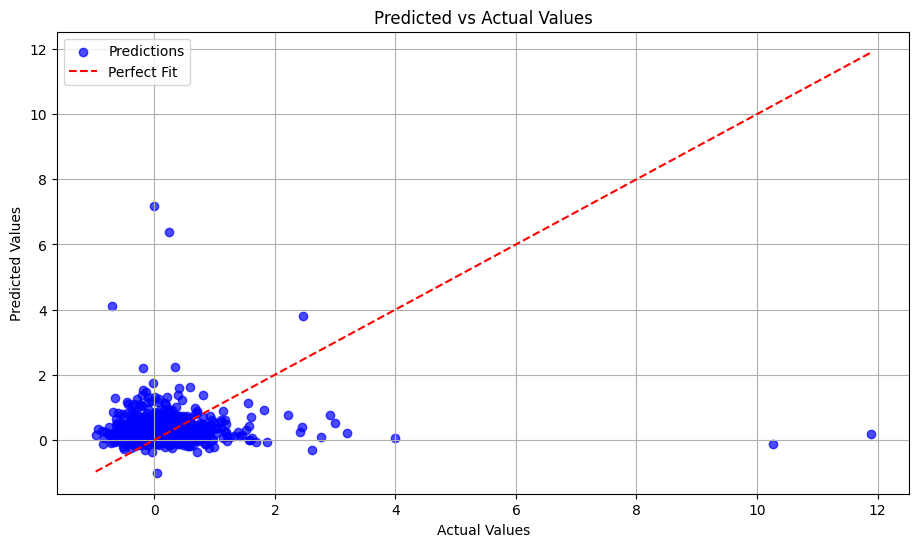

In [48]:
plt.figure(figsize=(11, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Fit')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

## Predictions